# Chapter 2: End-to-End Machine Learning Project

## Get the Data

Fetch housing.tgz file from GitHub and save it into the workspace

In [1]:
import os
import tarfile
from six.moves import urllib

DATASETS_URL = "https://github.com/ageron/handson-ml/raw/master/datasets"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DATASETS_URL + "/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.exists(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

Load the data from housing.csv to a Pandas DataFrame

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


`describe()`

+ count: null values are ignored
+ std: standard deviation
+ 25%, 50%, and 75% (quartiles): percentiles of the variable


<IPython.core.display.Javascript object>


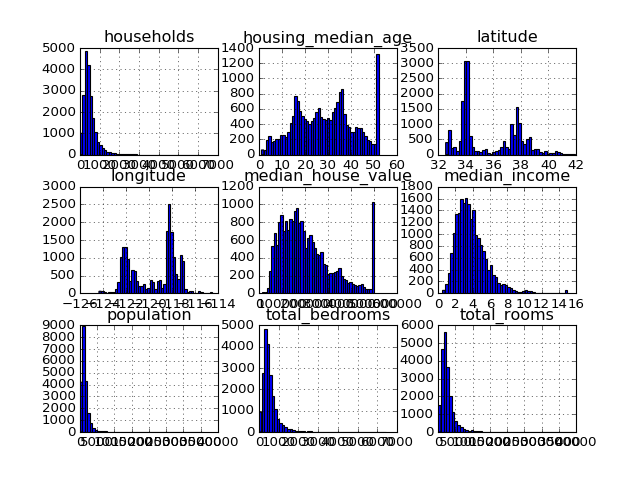

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fceebe475f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fceebc369b0>]], dtype=object)

In [7]:
%matplotlib notebook

import matplotlib.pyplot as plt

housing.hist(bins = 50)

### Create Test Set

_strata_ : division of populations into homogenous groups so that the sampling resembles the overall population.

**Example** :  A survey would try to maintain the ratio of women and men (_strata_ would be sex)

For this dataset, it is assumed that the median income feature is an important attribute. This is why it is important to ensure that the test set is representative of all the categories of incomes in the whole dataset. (_strata_ would be various income categories)

Since the median income is a continuous value, it is necessary to define discrete income categories. The discrete income categories are defined by dividing the `median_income` attribute by 1.5 and rounding up using the ceil function. Also, the categories greater than 5.0 are merged into the 5 category.

<IPython.core.display.Javascript object>


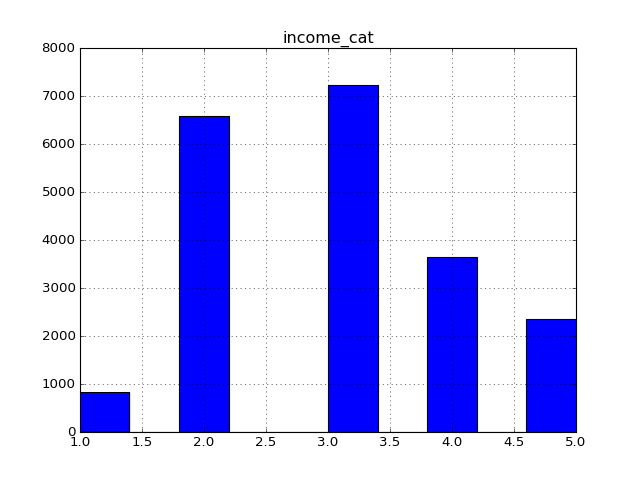

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fceeb510c18>]], dtype=object)

In [8]:
import numpy as np
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace = True)

housing.hist(column='income_cat')

Once the discrete feature is created, the sklearn function StratifiedShuffleSplit class can be used. This class is used to do stratified sampling based on the income category just created.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

** The stratified sampling has income category proportions almost identical to the ones in the dataset, while the test set generated using purely random sampling is skewed. The stratified sampling method is useful for creating test sets respresentative of the full dataset. **

Once the test set is created, the `income_cat` must be deleted to restore the data to its original state.

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace= True)

## Discover and Visualize the Data to Gain Insights

Create copy of train set to manipulate data without making changes to the actual dataset

In [11]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

+ s: radius of each circle
+ c: color of each circle

<IPython.core.display.Javascript object>


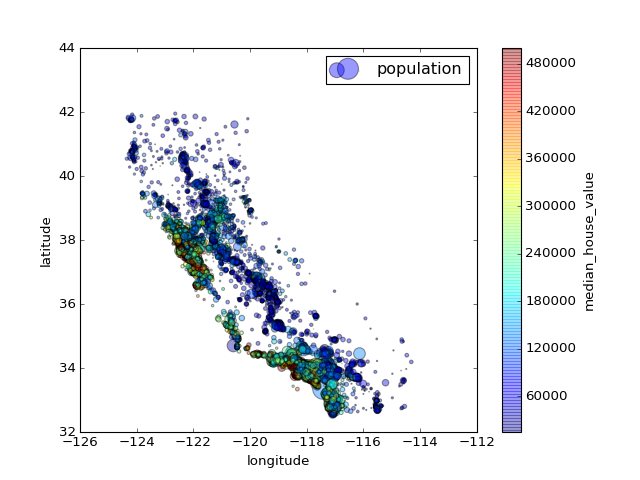

In [12]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude',alpha = 0.4, 
            s= housing['population']/100, label = 'population',
            c = "median_house_value", cmap=plt.get_cmap('jet'), colorbar = True)

### Looking for Correlations

When datasets are not too large, the _standard correlation coeffiecient_ (or _Pearson's r_) between each of the attributes can be calculated. The correlation coefficients range from -1 to 1, where 1 is a strong positive correlation and -1 is a strong negative correlation.

** Take into account:**

+ Correlation coefficients only measures linear correlations. They miss nonlinear relationships
+ Correlation coefficients have nothing to do with the slope of the graph.

In [13]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another way to check for correlations is the `scatter_matrix` function from Pandas. It is better to focus on the promising attributes since the number of plots is $n^2$, where $n$ is the number of attributes

<IPython.core.display.Javascript object>


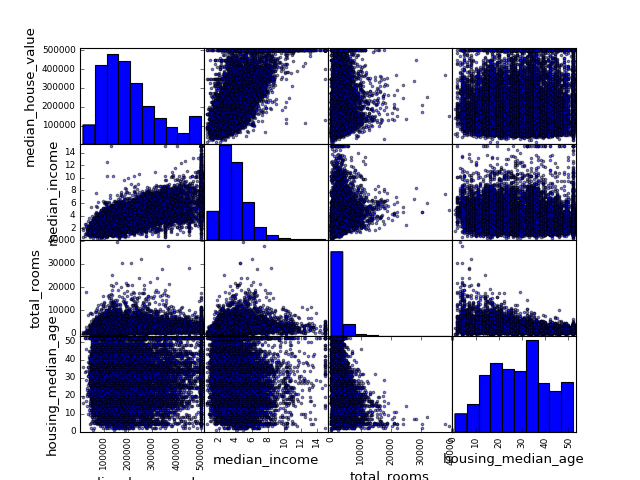

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fced115f0f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fced0f5eb38>]], dtype=object)

In [14]:
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes])

The most promising attribute to predict the median house value is the median income, because the points are not too dispersed and a trend can be observed.

<IPython.core.display.Javascript object>


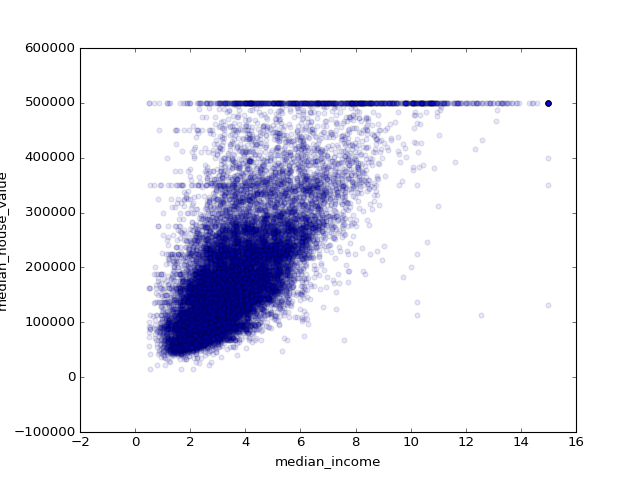

In [15]:
housing.plot(kind='scatter', x ='median_income', y = 'median_house_value', alpha = 0.1)

### Experimenting with Attribute Combinations

Create new attributes to gain further insight from the data. For example, create numbers of rooms per household, bedrooms per room and population per household.

In [16]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [17]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare Data for Machine Learning Algorithms

The first step is to separate the targer feature from the predictors

`drop()` creates a copy of the data and does not affect original DataFrame

In [18]:
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

The most common ways to deal with missing data are:

1. Get rid of the corresponding sample
2. Get rid of the entire attribute
3. Set the missing values so some value

```python
#Option 1
housing.dropna(subset=['total_bedrooms'])
#Option 2
housing.drop('total_bedrooms', axis = 1)
#Option 3
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace = True)
```

When option 3 is used, the median must be saved to later replace it in the test set and in new data that in the future.


** Handling missing values using sklearn **

1. Create instance of `Imputer` specifying that the missing values are going to be replaced by the median

In [19]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy = 'median')

The median can only be computed in numerical attributes. This is why the features that are strings must by dropped. Once this is done, the `fit()` method can be used to compute the median of all the attributes.

In [20]:
housing_num = housing.drop('ocean_proximity', axis = 1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

The `imputer` computes the median of each attribute and stores the result in `statistics_`. It is safer to apply the imputer to all attributes, even though some of them may not have missing values, because it is possible that in new data other features have missing values.

Once the median for all the attributes is calculated, the transformation to the dataset is applied.

In the future, instead of using `fit()` and `transform()` in separate lines, it would be more convenient to use `fit_transform()`. According to the book, this function can sometimes run faster than calling both methods separetely.

In [21]:
X = imputer.transform(housing_num)

### Handling Text and Categorical Attributes

The solution of simply dropping non-numeric attribute is not the best way to deal with categorical attributes. Intead the sklearn `LabelEncoder` should be used. (Note the use of `fit_transform()`)

To see which label corresponds to which category, use the `classes_` attribute.

In [22]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)
print(encoder.classes_)

[0 0 4 ..., 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


An issue with assigning labels this way to categorical attributes is that a ML algorithm may assume that two nearby values are more similar than two distant values. Since someties categories are not defined this way, a common solution to deal with categorical values is to create a binary attribute for each category. In the example of ocean proximity, 5 new attributes should be created. This is called _one-hot encoding_ and sklearn provides a tool to perform this transformation.

Note on `reshape()`: This function allows one dimension to be -1, which means 'unspecified' dimension that is inferred from the length of the array and the remaining dimensions. This function is necessary because `fit_transform()` expects a 2D array.

In [23]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))

The result of the transformation is a sparse matrix to save memory

The transformation 
*text categories &rarr; integer categories &rarr; one-hot vectors* 
was done in two steps. However, using the `LabelBinarizer`, this transformation can be done in only one step.

This class outputs by default a dense NumPy array. To save memory with the sparse matrix, `sparse_output=True` must me set in the constructor.

In [24]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)

### Custom Transformers

Sometimes it is necessary to create custom transformers that are not included in sklearn. These custom transformers should be built compatible with sklearn functionalities. Then, the custom transformers should have the methods `fit()`, `transform()`, and `fit_transform()`. The fit transform method can be added automatically if the class `TransformerMixin` is a base class of the custom transformer. Also, it is useful to add `BaseEstimator` as a base class because it includes the `get_params()` and `set_params()` methods that are useful for automatic hyperparameter tuning. (`*args` and `**kargs` should be avoided in the constructor. For more information see [Python Tips *args and *kargs](https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/))

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y = None):
        
        return self # Nothing else to do
    
    def transform(self, X, y=None):
        
        rooms_per_household = X[:, rooms_ix]/X[:, household_ix]
        population_per_household = X[:, population_ix]/X[:, household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

** Min-Max Scaling **:

+ Values are shifted and rescaled so they range from 0 to 1
+ Use `MinMaxScaler` from sklearn. Use `feature_range` from this class to change to a scaling range different from 0-1

** Standarization**

+ Does not bond values to specific range.
+ Much less affected by outliers.
+ Use `StandardScaler` from sklearn

**Note: As with all transformations, only fit the scalers with the training data set. Once the transfomer is fit with the training set, it can be used in both the training and test sets. **

### Transformation Pipelines

`Pipeline` class provides help to deal with sequence of transformations. The `Pipeline` constructor takes a list of estimators that defines the sequence of steps. All the estimators in the list except the last one must be transformers. The names of the estimators can be anything as long as they do not contain double underscores. 


When the `Pipeline's fit()` method is called, the `fit_transform()` methods of the transformers in the list are called passing the output of each transformer to the next. When the pipeline reached the final estimator, the method `fit()` is called. The pipeline object has the same methods as the final estimator.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Transformer to feed directly a Pandas DataFrame into the pipeline instead of having to convert it manually to a NumPy array.

The `DataFrameSelector` will select the desired attributes by name from the DataFrame and write them in a NumPy array. 

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

The objective now is to write two pipelines that process the numerical and categorical attributes respectively. Then, these two pipelines are merged into a single pipeline.

**Note the use of `list(DataFrame)` to extract the name of the columns in a DataFrame**

In [28]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [29]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer())
])

The class `FeatureUnion` is used to join the two created pipelines. This class takes a list of transformers, that in this case are transformer pipelines, and executes them in parallel and then concatenates their result. 

In short, `FeatureUnion` syntax works as a pipeline. It is a pipeline of pipelines.

In [31]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)

## Select and Train a Model

### Training and Evaluating on the Training Set

Start by training a Linear Regression model

Note that in this section the test set is not used. This is because it is better not to touch the test set until a model almost ready to launch is selected. 

In [32]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


Measure the Linear Regression model performance using RMSE

In [34]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

Try more complex model: DecisionTreeRegressor

In [36]:
from sklearn.tree import DecisionTreeRegressor


tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Better Evaluation Using Cross-Validation

An alternative for validation is using cross-validation. sklearn has a feature that allows to perform K-fold cross-validation. That is, randomly splitting the training set into $n$ sets called folds. Then, the model is trained in $n-1$ sets and then evaluated in the remaining set. This process is repeated $n$ times so the result are $n$ evaluation scores.

**Note on negative sign in scores:** sklearn cross-validation features expect a utility function (greater is better) instead of a cost function. This is why the scoring function is actually the opposite of MSE and the reason why a minus sign must be added to compute the actual MSE score

Cross-validation allows to have an estimate of the actual performance of the model using only the training set. Also, it allows to know how precise is the measurement of the performance score using the standard deviation of the $n$ scores obtained.

In [37]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [39]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [ 69281.67887869  67106.23221775  72017.87956068  69190.43151945
  70986.37116986  73952.32921394  70099.60476559  70935.67997192
  77516.62630226  71278.27592571]
Mean: 71236.5109526
Standard deviation: 2719.19906641


When choosing a model, it is convenient to save all the models tested including the hyperparameters used, the cross-validation scores, and the output of the model if possible. To save a model to access it later,the Python library `Pickle` can be used. Also, sklearn has the library `sklearn.externals.joblib`.

```python
from sklearn.externals import joblib

#To save it
joblib.dump(my_model, 'my_model.pkl')

#To load it
my_model_loaded = joblib.load('my_model.pkl')
```

## Fine-Tune Your Model

Once a list of around five promising models is gathered, it is time to fine-tune them to improve their performance. 

### Grid Search

The best way to explore multiple combinations of hyperparameters is using sklearn's `GridSearchCV`. This feature takes the values of certain hyperparameters, creates all the possible combinations, and evaluates them using cross-validation.

In the example, the 3x4 combinations of the first dictionary are evaluated followed by the 2x3 combinations of the other dictionary. The model will be trained 5 times since that is the parameter set for cross-validation. 

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3,10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'bootstrap': [False], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Once the GridSearch is finished, the best paramters and the best estimators can be accessed

In [43]:
grid_search.best_params_


{'max_features': 8, 'n_estimators': 30}

In [44]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

When `refit=True`, once `GridSearchCV` finds the best estimator it retrains the estimator on the whole set. This allows to improve the performance of the best model.

The GridSearch can also be used to determine whether it is a good idea to add certain features to the data. This can be done using `GridSearchCV` also. For example, in this case the function `add_bedrooms_per_room` can be made part of the search.

### Randomized Search

When the number of hyperparameters that want to be tried is large, it is a better idea to perform a `RandomizedSearchCV` instead of a `GridSearchCV`. The randomized search assigns random values to each parameters in every iteration.

Advantages:

+ Run combinations of parameters much faster.
+ More control over used computing power because it onlyl depends on the number of iterations.

### Analyze the Best Models and Their Errors 

Some models, such as the `RandomForestRegressor`, show the importance of each attribute to make predictions.}

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.04274920e-02,   6.48681055e-02,   3.98933651e-02,
         1.42212583e-02,   1.49975149e-02,   1.51769253e-02,
         1.36848053e-02,   3.27701659e-01,   4.81366043e-02,
         1.13405004e-01,   8.53951195e-02,   7.29958446e-03,
         1.79535802e-01,   1.25304941e-04,   2.17760961e-03,
         2.95384603e-03])

In [46]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']

cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.3277016590477666, 'median_income'),
 (0.17953580165053259, 'INLAND'),
 (0.11340500395968774, 'pop_per_hhold'),
 (0.085395119519807189, 'bedrooms_per_room'),
 (0.07042749200024416, 'longitude'),
 (0.06486810554092251, 'latitude'),
 (0.048136604326831402, 'rooms_per_hhold'),
 (0.03989336508191179, 'housing_median_age'),
 (0.015176925349376719, 'population'),
 (0.014997514903663798, 'total_bedrooms'),
 (0.014221258251459252, 'total_rooms'),
 (0.013684805326304859, 'households'),
 (0.0072995844621854883, '<1H OCEAN'),
 (0.0029538460251348438, 'NEAR OCEAN'),
 (0.0021776096131178478, 'NEAR BAY'),
 (0.00012530494105326111, 'ISLAND')]

### Evaluate the System on the Test Set

In [47]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47634.174381401695

## Launch, Monitor, and Maintain the System

Writing monitoring code is necessary to check for the performance of the system. It is common that the performance of the model drops, because data evolves over time. This is why models must be trained on fresh data.

The output of the tool must also be evaluated by human analysis. 

The input data quality must be also evaluated, because sometimes the quality of the data degrades. For example, a sensor that send data could be malfunctioning sending random values.

** Train the model on a regular basis using fresh data**. Try to automate the training of the model.